# This notebook will read, clean, and organize the WNV data to prepare for Exploratory Data Analysis.  
### Blaine Murphy 
### July 2021


In [1]:
### Import Relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
import seaborn as sns


In [2]:
### Set folder containing the input data files
folder = '../input/'

## Training Set

In [3]:
### First import training set
train=pd.read_csv(folder + 'train.csv')
train.head(5)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
### High level of train examination
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


The objective here is to create a model that will predict where there will be a positive West Nile virus test from a mosquito trap based on time, spraying, weather, and location.  The target value is 'WnvPresent' and it's values are 1 for a positive test in that mosquito trap and 0 for negative test. 

There do not appear to be any null values in the training set to deal with.  Next I will change a few data types in the training set and extract the ZIP code from the address column, that may be useful.   

In [5]:
### Set some column types here
train['Date'] = pd.to_datetime(train['Date'])
train['Trap'] = pd.Categorical(train['Trap'])
train['Species'] = pd.Categorical(train['Species'])

### Extracting the ZIP from the address may be useful, I'll do that here
### Regex looks for 5 numeric characters in a row and returns them as a string
train['ZIP'] = train['Address'].str.findall('[0-9]{5}').str.join('').replace('',np.nan)

In [6]:
train.ZIP.nunique()
#train.ZIP.value_counts()

50

The mosquito traps are located in 50 different zip codes. However, there were some addresses that did not contain 5 digit ZIPs.  I'll try to fix this now.

In [7]:
train[train.ZIP.isnull()]['Trap'].unique()

['T089', 'T145', 'T014', 'T115', 'T138', ..., 'T102', 'T157', 'T227', 'T226', 'T229']
Length: 12
Categories (12, object): ['T089', 'T145', 'T014', 'T115', ..., 'T157', 'T227', 'T226', 'T229']

There are 12 traps that do not have a ZIP.  Can I identify a time efficient and repeatable way of imputing the correct ZIP? 

In [8]:
#train[train['Trap']=='T089']
#train[train['Street'].str.contains('S VINCENNES')]

### Street name is unqiue to this trap


#train[train['Trap']=='T145']
#train[train['Street'].str.contains('ASHLAND AVE OVERPASS')]


For now I cannot come up with a way to impute the missing values of ZIP to the dataset.  For now I will drop this column before exporting the clean data at the end of this section. 

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  category      
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  category      
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  ZIP                     8998 non-null   object

In [10]:
train.Species.value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

It appears in some instances that 2 of the mosquito species are lumped into one category called 'CULEX PIPIENS/RESTUANS'.  Note there are about equal numbers of Restuans and Pipiens in the data set and an almost equal number in those two combined as they are in the combined category.

In [11]:
train.Trap.value_counts()

T900     750
T115     542
T138     314
T002     185
T135     183
        ... 
T238       7
T076       5
T094B      5
T237       3
T040       2
Name: Trap, Length: 136, dtype: int64

The documentation says traps are not recorded if they didn't collect any mosquitos, which probably results in the differing counts records.  

First date: 2007-05-29 00:00:00
Last date: 2013-09-26 00:00:00


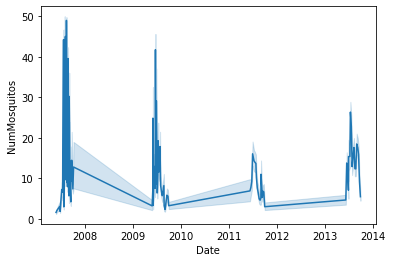

In [12]:
### To get an idea of the date range for these records

print('First date:',train.Date.min())
print('Last date:',train.Date.max())
sns.lineplot(data=train,x='Date',y='NumMosquitos');

The training data spans the summer months in 2007, 2009, 2011, and 2013.  The documentation says that the testing day will be for 2008, 2010, 2012, and 2014 I believe.  

In [13]:
### Quick look at the number of positive cases

print(train.shape)

train.WnvPresent.value_counts()/train.shape[0]

(10506, 13)


0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

This is a heavily imbalanced dataset.  ~95% of records return a negative result for the mosquito test, while only 5% return a potivie test.  It looks to be in pretty good shape at the moment for analysis and modeling.


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  category      
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  category      
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
 12  ZIP                     8998 non-null   object

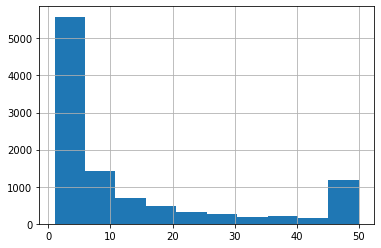

In [15]:
### Histogram of the number of mosquitos collected
train.NumMosquitos.hist();

The documentation says the records are limited to 50 mosquito samples.  For traps greater than 50 a new record is created.  To tidy the data for modeling I need to consolodate these records into one.  I need to sum the number of mosquitos caught, capture if there was a positive test, and capture the species in the combined record, while all of the other elements should be the same. First let's find the number of records I should have in the end by finding how many unique rows there are for `Date` and `Trap`.

In [16]:
dummy = train.groupby(['Date','Trap']).size().reset_index()
print(dummy.shape)
dummy = dummy[dummy[0]!=0]
print(dummy.shape)
#dummy[0]

(12920, 3)
(4616, 3)


In [17]:
train.shape

(10506, 13)

A quick check of the data integrity in the training set.  

In [18]:
dummy = train.groupby(['Trap','Latitude','Longitude']).size().reset_index()
print(dummy.shape)
dummy = dummy[dummy[0]!=0]
print(dummy.shape)
#dummy[0]

(2589984, 4)
(138, 4)


In [19]:
train.Trap.nunique()

136

It looks like there are 2 cases of traps with different latitudes and longitudes.  I will see if this is an error or not.  

In [20]:
dummy[dummy.duplicated('Trap')]

,Trap,Latitude,Longitude,0
169880,T009,41.992478,-87.862995,80
484871,T035,41.836644,-87.677737,27


In [21]:
dummy[dummy.Trap.str.contains('T009')]

,Trap,Latitude,Longitude,0
169055,T009,41.981964,-87.812827,31
169880,T009,41.992478,-87.862995,80


In [22]:
dummy[dummy.Trap.str.contains('T035')]

,Trap,Latitude,Longitude,0
481244,T035,41.763733,-87.742302,45
484871,T035,41.836644,-87.677737,27


At some point the traps were moved? I will and an `a` to the Trap name with the new Latitude and longitude in each case.  That way the traps will not be aggreggated incorrectly.  

In [23]:
train['Trap'] = train.Trap.cat.add_categories(['T035a','T009a'])

In [24]:
mask = (train.Trap=='T035') & (train.Latitude==41.763733) & (train.Longitude==-87.742302)
train.loc[mask,'Trap'] = 'T035a'

In [25]:
mask = (train.Trap=='T009') & (train.Latitude==41.992478) & (train.Longitude==-87.862995)
train.loc[mask,'Trap'] = 'T009a'

Boom, now these two traps can be aggregated correctly.  

In [26]:
dummy = train.groupby(['Date','Trap']).size().reset_index()
print(dummy.shape)
dummy = dummy[dummy[0]!=0]
print(dummy.shape)

(13110, 3)
(4616, 3)


It looks like the training data only consits of 4,616 unique dates and trap locations.  Now we will aggregate the duplicate records to create single observations for dates and traps. That is too big of a reduction to account for the number of records that exactly equal 50.  Why else would their be duplicate records?

In [27]:
dummy = train.groupby(['Date','Trap','Species']).size().reset_index()
dummy = dummy[dummy[0]!=0]
dummy.shape

(8475, 4)

This looks much closer to the number of additional records due to samples greater than 50 mosquitos. Some records are seperated by mosquito species.  

That raises the question should I keep different species samples collected at the same time and the same place in different records or should I lump them into one observation and capture the range of species in that sample? A quick internet search leads me to believe that certain mosquito species are more likely to carry WNV than others.  ~Given this possibility I will not lump together mosquito species for now.~  

I found a document from the CDC that says all of these mosquito species are capable carrying WNV and infecting humans.  Plus this obviously not something that is available in the test set, so I will aggregate these records as well.

In [28]:
list(train.Species.unique())

['CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX PIPIENS',
 'CULEX SALINARIUS',
 'CULEX TERRITANS',
 'CULEX TARSALIS',
 'CULEX ERRATICUS']

In [29]:
### Function for aggregating mosquito species into a single record
### to be used in groupby.agg() to capture all species of mosquito
### taken in sample

### Not used at this time

def AggSpecies(ser):
    """Function to pass to groupby agg to combine the mosquito species column"""
    ser = list(ser)
    spec = []
    for i in ser:
        if '/' in i:
            dum = i.replace('CULEX ','')
            for ii in dum.split('/'):
                spec.append(ii)
        else:
            spec.append(i.replace('CULEX ',''))
    return 'CULEX ' +'/'.join(list(sorted(set(spec))))
        

In [30]:
### Aggregate the NumMosquitos by summing and 
### WnvPresent with Max 

agg_records = train.groupby(by = ['Date','Trap']).agg({'Species':AggSpecies,'NumMosquitos':'sum','WnvPresent':'max'}).fillna(0.).reset_index()
agg_records = agg_records[agg_records.NumMosquitos!=0.].reset_index(drop=True)
agg_records.shape

(4616, 5)

Perfect that is the number of unique combinations of  `Trap` and `Date` I found earlier


In [31]:
agg_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4616 non-null   datetime64[ns]
 1   Trap          4616 non-null   category      
 2   Species       4616 non-null   object        
 3   NumMosquitos  4616 non-null   int64         
 4   WnvPresent    4616 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 158.5+ KB


In [32]:
agg_records.duplicated(subset=['Date','Trap']).sum()

0

And now I will create new columns that represent what species was sampled in the trap on that date.

In [33]:
specs = ['RESTUANS','PIPIENS','SALINARIUS','TERRITANS','TARSALIS','ERRATICUS']
for s in specs:
    agg_records[s] = 0
    agg_records[s] = np.where(agg_records['Species'].str.contains(s),1,0)


In [34]:
agg_records.head()

,Date,Trap,Species,NumMosquitos,WnvPresent,RESTUANS,PIPIENS,SALINARIUS,TERRITANS,TARSALIS,ERRATICUS
0,2007-05-29,T002,CULEX PIPIENS/RESTUANS,2,0.0,1,1,0,0,0,0
1,2007-05-29,T007,CULEX RESTUANS,1,0.0,1,0,0,0,0,0
2,2007-05-29,T015,CULEX PIPIENS/RESTUANS,5,0.0,1,1,0,0,0,0
3,2007-05-29,T045,CULEX RESTUANS,2,0.0,1,0,0,0,0,0
4,2007-05-29,T046,CULEX RESTUANS,1,0.0,1,0,0,0,0,0


In [35]:
agg_records.describe()

,NumMosquitos,WnvPresent,RESTUANS,PIPIENS,SALINARIUS,TERRITANS,TARSALIS,ERRATICUS
count,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000
mean,29.254549,0.083406,0.938475,0.895581,0.017981,0.046794,0.001300,0.000217
std,118.533327,0.276524,0.240317,0.305837,0.132896,0.211220,0.036034,0.014719
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,20.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,3002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Looks good, now I will drop the now unnecessary `Species` column.

In [36]:
agg_records.drop('Species',axis=1,inplace=True)
agg_records.shape

(4616, 10)

That looks like the right shape.  Now I need to join the other columns from the original dataframe to these columns in the aggregated records. 

In [37]:
#merge_columns = ['Address', 'Block','Street','AddressNumberAndStreet','Latitude','Longitude','AddressAccuracy','ZIP']
train_ed = agg_records.merge(train,how = 'left',on = ['Date','Trap'],\
                             suffixes=['','_orig'],validate='1:m')
train_ed.head(3)

,Date,Trap,NumMosquitos,WnvPresent,RESTUANS,PIPIENS,SALINARIUS,TERRITANS,TARSALIS,ERRATICUS,...,Species,Block,Street,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos_orig,WnvPresent_orig,ZIP
0,2007-05-29,T002,2,0.0,1,1,0,0,0,0,...,CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,60634
1,2007-05-29,T002,2,0.0,1,1,0,0,0,0,...,CULEX RESTUANS,41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,60634
2,2007-05-29,T007,1,0.0,1,0,0,0,0,0,...,CULEX RESTUANS,62,N MANDELL AVE,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,60646


In [38]:
### A little clean up after merge
train_ed = train_ed.drop(['NumMosquitos_orig','WnvPresent_orig','Species'],axis = 1)

colz = ['Date','Trap','Address', 'Block','Street','AddressNumberAndStreet']
colz += ['Latitude','Longitude','AddressAccuracy','ZIP']
colz += specs  # adding species columns 
colz += ['NumMosquitos','WnvPresent']


train_ed = train_ed[colz]
train_ed.drop_duplicates(inplace = True)
train_ed.reset_index(drop = True, inplace =True)
train_ed.shape

(4616, 18)

That looks like the right shape.  Now I'll double check the dataframe and column types before exporting the cleaned data.

In [39]:
train_ed.head()

,Date,Trap,Address,Block,Street,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,ZIP,RESTUANS,PIPIENS,SALINARIUS,TERRITANS,TARSALIS,ERRATICUS,NumMosquitos,WnvPresent
0,2007-05-29,T002,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,60634,1,1,0,0,0,0,2,0.0
1,2007-05-29,T007,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,60646,1,0,0,0,0,0,1,0.0
2,2007-05-29,T015,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,60656,1,1,0,0,0,0,5,0.0
3,2007-05-29,T045,"1500 West Webster Avenue, Chicago, IL 60614, USA",15,W WEBSTER AVE,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,60614,1,0,0,0,0,0,2,0.0
4,2007-05-29,T046,"2500 West Grand Avenue, Chicago, IL 60654, USA",25,W GRAND AVE,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,60654,1,0,0,0,0,0,1,0.0


In [40]:
train_ed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    4616 non-null   datetime64[ns]
 1   Trap                    4616 non-null   category      
 2   Address                 4616 non-null   object        
 3   Block                   4616 non-null   int64         
 4   Street                  4616 non-null   object        
 5   AddressNumberAndStreet  4616 non-null   object        
 6   Latitude                4616 non-null   float64       
 7   Longitude               4616 non-null   float64       
 8   AddressAccuracy         4616 non-null   int64         
 9   ZIP                     4162 non-null   object        
 10  RESTUANS                4616 non-null   int32         
 11  PIPIENS                 4616 non-null   int32         
 12  SALINARIUS              4616 non-null   int32   

In [41]:
### I will drop the ZIP code column for now because I can't come up with 
### a repeatable way of correctly filling in missing values
train_ed.drop('ZIP',axis=1,inplace=True)

In [42]:

train_ed.to_csv('train_clean.csv')

In [43]:
train_ed.shape

(4616, 17)

In [44]:
train_ed.head()

,Date,Trap,Address,Block,Street,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,RESTUANS,PIPIENS,SALINARIUS,TERRITANS,TARSALIS,ERRATICUS,NumMosquitos,WnvPresent
0,2007-05-29,T002,"4100 North Oak Park Avenue, Chicago, IL 60634,...",41,N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,1,0,0,0,0,2,0.0
1,2007-05-29,T007,"6200 North Mandell Avenue, Chicago, IL 60646, USA",62,N MANDELL AVE,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,0,0,0,0,1,0.0
2,2007-05-29,T015,"7900 West Foster Avenue, Chicago, IL 60656, USA",79,W FOSTER AVE,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,1,0,0,0,0,5,0.0
3,2007-05-29,T045,"1500 West Webster Avenue, Chicago, IL 60614, USA",15,W WEBSTER AVE,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,1,0,0,0,0,0,2,0.0
4,2007-05-29,T046,"2500 West Grand Avenue, Chicago, IL 60654, USA",25,W GRAND AVE,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0,0,0,0,0,1,0.0


Cleaning of train data is now complete.  I will follow the same process for the test set next.  

## Wrangling of test set

In [45]:
### Import test dataset
test = pd.read_csv(folder+'test.csv')
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [46]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


The test set is much longer, 10 times as long.  It includes all traps and dates, whereas the training data didn't include traps and dates that didn't collect any samples.  It includes an additional column `Id`, but this appears to just be the row index for the file.  Compared to the training set it is missing the `NumMosquitos` and the `WnvPresent` column  I will drop this Id column and do the same type conversions as in the test set.

In [47]:
test = test.drop('Id',axis=1)

test['Date'] = pd.to_datetime(test['Date'])
test['Trap'] = pd.Categorical(test['Trap'])
test['Species'] = pd.Categorical(test['Species'])

## Regex looks for 5 numeric characters in a row and returns them as a string
test['ZIP'] = test['Address'].str.findall('[0-9]{5}').str.join('').replace('',np.nan)

In [48]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    116293 non-null  datetime64[ns]
 1   Address                 116293 non-null  object        
 2   Species                 116293 non-null  category      
 3   Block                   116293 non-null  int64         
 4   Street                  116293 non-null  object        
 5   Trap                    116293 non-null  category      
 6   AddressNumberAndStreet  116293 non-null  object        
 7   Latitude                116293 non-null  float64       
 8   Longitude               116293 non-null  float64       
 9   AddressAccuracy         116293 non-null  int64         
 10  ZIP                     106359 non-null  object        
dtypes: category(2), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 8.3+ MB


First date: 2008-06-11 00:00:00
Last date: 2014-10-02 00:00:00


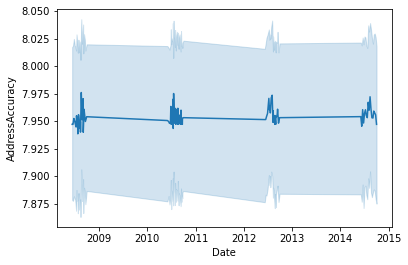

In [49]:
### To get an idea of the date range for these records

print('First date:',test.Date.min())
print('Last date:',test.Date.max())
sns.lineplot(data=test,x='Date',y='AddressAccuracy');

The test set contains data for summer months in the years 2008, 2010, 2012, and 2014.

There is no need to do the same aggretations as in the training data. I will double check all column types before exporting.


In [50]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Date                    116293 non-null  datetime64[ns]
 1   Address                 116293 non-null  object        
 2   Species                 116293 non-null  category      
 3   Block                   116293 non-null  int64         
 4   Street                  116293 non-null  object        
 5   Trap                    116293 non-null  category      
 6   AddressNumberAndStreet  116293 non-null  object        
 7   Latitude                116293 non-null  float64       
 8   Longitude               116293 non-null  float64       
 9   AddressAccuracy         116293 non-null  int64         
 10  ZIP                     106359 non-null  object        
dtypes: category(2), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 8.3+ MB


For now I will drop the ZIP column until I can come up with an efficient and accurate way of filling those null values

In [51]:
test.drop('ZIP',axis=1,inplace=True)

In [52]:
test.to_csv('test_clean.csv')

## Mosquito spraying data

In [53]:
### First read in data and inspect
spray=pd.read_csv(folder + 'spray.csv')
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [54]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


There are ~600 missing values in the `Time` column, but the other columns look good so far. 

In [55]:
### To get an idea of the date range
print(pd.to_datetime(spray['Date']+' '+spray['Time']).min())
print(pd.to_datetime(spray['Date']+' '+spray['Time']).max())

2011-08-29 18:56:58
2013-09-05 20:40:56


Now I will inspect the missing values in the `Time` column

In [56]:
spray[spray.Time.isnull()]['Date'].value_counts()

2011-09-07    584
Name: Date, dtype: int64

There are 584 missing values in the `Time` column and they all occur on the same day, `2011-09-07`. 

After exploring the data a little I noticed there are also duplicates.

In [57]:
spray[spray.duplicated()].Date.value_counts()

2011-09-07    541
Name: Date, dtype: int64

There are in fact 541 duplicates and they are all on the same day as the null values.  Since they are complete duplicate rows, I will drop the duplicates from the dataframe.

In [58]:
### After exploring the data I noticed there are complete
### duplicate rows.  Those will be removed now.

spray.drop_duplicates(keep='first',inplace=True)
spray.reset_index(inplace=True,drop=True)
spray.shape

(14294, 4)

In [59]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14294 entries, 0 to 14293
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14294 non-null  object 
 1   Time       13710 non-null  object 
 2   Latitude   14294 non-null  float64
 3   Longitude  14294 non-null  float64
dtypes: float64(2), object(2)
memory usage: 446.8+ KB


After dropping the duplicate rows, there are still ~500 missing `Time` values.  I will see if the spraying follows a consistent pattern so that I might fill these nulls.

In [60]:
spray['Timenull'] = (spray['Time'].isnull()) * 1

odd_day=spray[spray['Date'] == '2011-09-07']

<Figure size 432x288 with 0 Axes>

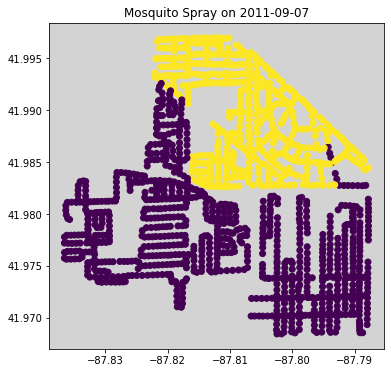

In [61]:
plt.set_cmap('viridis')
plt.figure(figsize=(6,6))
ax=plt.axes()
#odd_day.plot(y='Latitude',x='Longitude',kind='scatter',color=odd_day.Timenull)
ax.set_facecolor('lightgrey')
plt.scatter(x=odd_day.Longitude,y=odd_day.Latitude,c=odd_day.Timenull)
plt.title('Mosquito Spray on 2011-09-07')
plt.show()

The missing `Time` values look like they are from a continuous section of the spraying route.  Maybe I can find the beginning and end times as well as the frequency to fill in the time values.  

In [62]:
firstnull = odd_day[odd_day['Time'].isnull()].index.min()
lastnull = odd_day[odd_day['Time'].isnull()].index.max()
print(odd_day.loc[firstnull-5:firstnull])
print()
print(odd_day.loc[lastnull:lastnull+5])

           Date        Time   Latitude  Longitude  Timenull
484  2011-09-07  7:43:40 PM  41.983917 -87.793088         0
485  2011-09-07  7:44:02 PM  41.984988 -87.793563         0
486  2011-09-07  7:44:12 PM  41.985455 -87.793797         0
487  2011-09-07  7:44:20 PM  41.985865 -87.793980         0
488  2011-09-07  7:44:32 PM  41.986460 -87.794225         0
489  2011-09-07         NaN  41.987092 -87.794286         1

            Date        Time   Latitude  Longitude  Timenull
1072  2011-09-07         NaN  41.993092 -87.810415         1
1073  2011-09-07  7:46:30 PM  41.973465 -87.827643         0
1074  2011-09-07  7:46:40 PM  41.973457 -87.828302         0
1075  2011-09-07  7:46:50 PM  41.973435 -87.829073         0
1076  2011-09-07  7:47:00 PM  41.973442 -87.829835         0
1077  2011-09-07  7:47:10 PM  41.973418 -87.830568         0


The null time values are in a certain part of the spray run and are most certainly sequential with the same frequency as the rest of the spray run on that day.  I just need to know the beginning, end and frequency to fill in the null values. 

In [63]:
### Number of null records
print('# of Nulls')
print(odd_day.Time.isnull().sum())
print()
print('Missing Time (s)')
print(60*2+30-32)

# of Nulls
584

Missing Time (s)
118


It looks like the usual frequency of the data is 10 seconds, so that is too many null records to fill in the time gap of in the data.  Let's check the time series of that whole day.

In [64]:
odd_day['dTime'] = pd.to_datetime(odd_day['Time'])
odd_day['Time_sec'] = odd_day['dTime'].dt.second + 60*odd_day['dTime'].dt.minute + 60*60*odd_day['dTime'].dt.hour
odd_day.sort_values('dTime').head()

C:\Users\blain\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\blain\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Time,Latitude,Longitude,Timenull,dTime,Time_sec
476,2011-09-07,7:42:12 PM,41.982767,-87.788192,0,2021-07-27 19:42:12,70932.0
477,2011-09-07,7:42:22 PM,41.982727,-87.788737,0,2021-07-27 19:42:22,70942.0
478,2011-09-07,7:42:32 PM,41.982743,-87.789485,0,2021-07-27 19:42:32,70952.0
479,2011-09-07,7:42:42 PM,41.982742,-87.790277,0,2021-07-27 19:42:42,70962.0
480,2011-09-07,7:42:52 PM,41.982753,-87.791015,0,2021-07-27 19:42:52,70972.0


In [65]:
odd_day['dTime_delta'] = odd_day.dTime.diff().shift(-1)
odd_day['dTime_delta_sec'] = odd_day.dTime_delta.dt.seconds
odd_day['dTime_delta_sec'].value_counts().sort_index()

C:\Users\blain\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\blain\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


6.0          1
8.0          1
9.0         13
10.0       874
11.0        13
12.0         1
13.0         1
15.0         1
20.0        39
22.0         1
30.0        15
31.0         1
34.0         1
39.0         1
40.0         9
50.0         5
60.0         2
80.0         2
90.0         2
100.0        3
81000.0      1
Name: dTime_delta_sec, dtype: int64

As I suspected the usual frequency of the records is 10 seconds.  I will create a plot of the route colored by the time of day in seconds to see whats going on.

<Figure size 432x288 with 0 Axes>

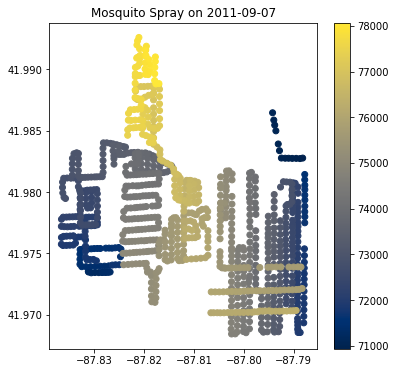

In [66]:
total = odd_day.copy()

plt.set_cmap('cividis')
plt.figure(figsize=(6,6))
ax=plt.axes()
#odd_day.plot(y='Latitude',x='Longitude',kind='scatter',color=odd_day.Timenull)
#ax.set_facecolor('lightgrey')
plt.scatter(x=total.Longitude,y=total.Latitude,c=total.Time_sec)
plt.title('Mosquito Spray on 2011-09-07')
plt.colorbar()
plt.show()

This plot shows that there is more than one mosquito spraying run, because there are obviously 2 contemporaneous routes. (The null times don't show up at all but are to the top of the plot).  I will check to make sure.

<Figure size 432x288 with 0 Axes>

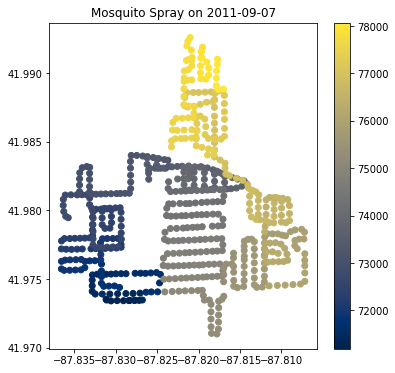

In [67]:
west = odd_day[odd_day['Longitude'] < -87.807]

plt.set_cmap('cividis')
plt.figure(figsize=(6,6))
ax=plt.axes()

plt.scatter(x=west.Longitude,y=west.Latitude,c=west.Time_sec)
plt.title('Mosquito Spray on 2011-09-07')
plt.colorbar()
plt.show()

In [68]:
west.sort_values('Time_sec').head(3)

,Date,Time,Latitude,Longitude,Timenull,dTime,Time_sec,dTime_delta,dTime_delta_sec
1073,2011-09-07,7:46:30 PM,41.973465,-87.827643,0,2021-07-27 19:46:30,71190.0,0 days 00:00:10,10.0
1074,2011-09-07,7:46:40 PM,41.973457,-87.828302,0,2021-07-27 19:46:40,71200.0,0 days 00:00:10,10.0
1075,2011-09-07,7:46:50 PM,41.973435,-87.829073,0,2021-07-27 19:46:50,71210.0,0 days 00:00:10,10.0


<Figure size 432x288 with 0 Axes>

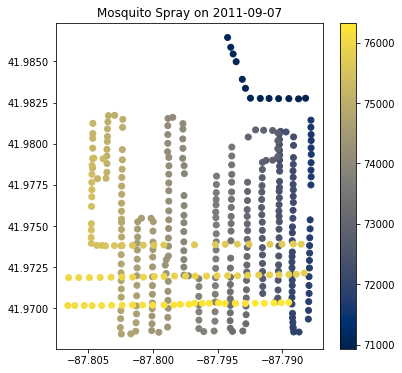

In [69]:
east = odd_day[odd_day['Longitude'] > -87.807]

plt.set_cmap('cividis')
plt.figure(figsize=(6,6))
ax=plt.axes()
#odd_day.plot(y='Latitude',x='Longitude',kind='scatter',color=odd_day.Timenull)
#ax.set_facecolor('lightgrey')
plt.scatter(x=east.Longitude,y=east.Latitude,c=east.Time_sec)
plt.title('Mosquito Spray on 2011-09-07')
plt.colorbar()
plt.show()

In [70]:
east.sort_values('Time_sec').head(3)

,Date,Time,Latitude,Longitude,Timenull,dTime,Time_sec,dTime_delta,dTime_delta_sec
476,2011-09-07,7:42:12 PM,41.982767,-87.788192,0,2021-07-27 19:42:12,70932.0,0 days 00:00:10,10.0
477,2011-09-07,7:42:22 PM,41.982727,-87.788737,0,2021-07-27 19:42:22,70942.0,0 days 00:00:10,10.0
478,2011-09-07,7:42:32 PM,41.982743,-87.789485,0,2021-07-27 19:42:32,70952.0,0 days 00:00:10,10.0


Yes they are 2 runs at the same time and they both start at about 7:45 PM.  I will assume that the missing `Time` values are a third run that starts at about the same time as these with 10 s periodicity.

In [71]:
### Split dataset into time null and time not null
spray_tnull = spray[spray['Time'].isnull()].reset_index(drop=True)
spray_tnotnull = spray[spray['Time'].notnull()]

In [72]:
spray_tnull

,Date,Time,Latitude,Longitude,Timenull
0,2011-09-07,NaN,41.987092,-87.794286,1
1,2011-09-07,NaN,41.987620,-87.794382,1
2,2011-09-07,NaN,41.988004,-87.794574,1
3,2011-09-07,NaN,41.988292,-87.795486,1
4,2011-09-07,NaN,41.988100,-87.796014,1
...,...,...,...,...,...
579,2011-09-07,NaN,41.995876,-87.811615,1
580,2011-09-07,NaN,41.995972,-87.810271,1
581,2011-09-07,NaN,41.995684,-87.810319,1
582,2011-09-07,NaN,41.994724,-87.810415,1


Creation of a new date time series to fill the null values based on the previously stated assumption.

In [73]:
interval = timedelta(seconds=10)
start = datetime(year = 2011, month = 9, day = 7, hour=19, minute = 45, second = 0)

dum = []

for _ in range(584):
    start+=interval
    dum.append(start)
dum = pd.Series(dum,name='dateTime')
spray_tnull = spray_tnull.join(dum)
spray_tnull

,Date,Time,Latitude,Longitude,Timenull,dateTime
0,2011-09-07,NaN,41.987092,-87.794286,1,2011-09-07 19:45:10
1,2011-09-07,NaN,41.987620,-87.794382,1,2011-09-07 19:45:20
2,2011-09-07,NaN,41.988004,-87.794574,1,2011-09-07 19:45:30
3,2011-09-07,NaN,41.988292,-87.795486,1,2011-09-07 19:45:40
4,2011-09-07,NaN,41.988100,-87.796014,1,2011-09-07 19:45:50
...,...,...,...,...,...,...
579,2011-09-07,NaN,41.995876,-87.811615,1,2011-09-07 21:21:40
580,2011-09-07,NaN,41.995972,-87.810271,1,2011-09-07 21:21:50
581,2011-09-07,NaN,41.995684,-87.810319,1,2011-09-07 21:22:00
582,2011-09-07,NaN,41.994724,-87.810415,1,2011-09-07 21:22:10


Now recombine spray data frames into one and clean up extraneous columns so that it is ready for use. But first I will create a datetime column in the not null dataframe.

In [74]:
### Create datetime column in not null data frame
spray_tnotnull['dateTime'] = pd.to_datetime(spray_tnotnull['Date'] + ' ' + spray_tnotnull['Time'])

C:\Users\blain\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
spray_tnotnull

,Date,Time,Latitude,Longitude,Timenull,dateTime
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,0,2011-08-29 18:56:58
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,0,2011-08-29 18:57:08
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,0,2011-08-29 18:57:18
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,0,2011-08-29 18:57:28
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,0,2011-08-29 18:57:38
...,...,...,...,...,...,...
14289,2013-09-05,8:34:11 PM,42.006587,-87.812355,0,2013-09-05 20:34:11
14290,2013-09-05,8:35:01 PM,42.006192,-87.816015,0,2013-09-05 20:35:01
14291,2013-09-05,8:35:21 PM,42.006022,-87.817392,0,2013-09-05 20:35:21
14292,2013-09-05,8:35:31 PM,42.005453,-87.817423,0,2013-09-05 20:35:31


Now these two dataframes can be concatenated. 

In [76]:
spray_ed = pd.concat([spray_tnotnull,spray_tnull]).sort_values('dateTime').reset_index(drop=True)
spray_ed

,Date,Time,Latitude,Longitude,Timenull,dateTime
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,0,2011-08-29 18:56:58
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,0,2011-08-29 18:57:08
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,0,2011-08-29 18:57:18
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,0,2011-08-29 18:57:28
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,0,2011-08-29 18:57:38
...,...,...,...,...,...,...
14289,2013-09-05,8:40:16 PM,42.001388,-87.811297,0,2013-09-05 20:40:16
14290,2013-09-05,8:40:26 PM,42.000962,-87.811843,0,2013-09-05 20:40:26
14291,2013-09-05,8:40:36 PM,42.000553,-87.812330,0,2013-09-05 20:40:36
14292,2013-09-05,8:40:46 PM,42.000955,-87.813083,0,2013-09-05 20:40:46


Excellent.  Now I will drop the extraneous columns and export out the clean dataset.  

In [77]:
spray_ed = spray_ed.drop(['Timenull','Date','Time'],axis=1).set_index('dateTime',drop=True)

In [78]:
spray_ed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14294 entries, 2011-08-29 18:56:58 to 2013-09-05 20:40:56
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   14294 non-null  float64
 1   Longitude  14294 non-null  float64
dtypes: float64(2)
memory usage: 335.0 KB


~~Looking good.~~

There are outliers as seen in the map of my EDA notebook.  I will fix that here

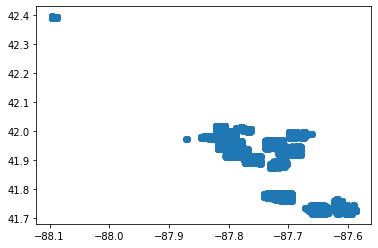

In [79]:
plt.scatter(x=spray_ed.Longitude,y=spray_ed.Latitude);
#plt.xlim((-87.9,-87.8))
### outliers or bad data

In [80]:
spray_ed[spray_ed.Latitude>42.2]

,Latitude,Longitude
dateTime,,
2011-08-29 18:56:58,42.391623,-88.089163
2011-08-29 18:57:08,42.391348,-88.089163
2011-08-29 18:57:18,42.391022,-88.089157
2011-08-29 18:57:28,42.390637,-88.089158
2011-08-29 18:57:38,42.390410,-88.088858
...,...,...
2011-08-29 19:14:38,42.392902,-88.093853
2011-08-29 19:14:48,42.392587,-88.093867
2011-08-29 19:14:58,42.392308,-88.093873


These appear to be either incorrect or irrelevent to this project.  I will drop these now before exporting. 

In [81]:
spray_ed = spray_ed[spray_ed.Latitude<42.2]

In [82]:
### One final fix for lonely data point that looks erroneous
#spray_ed.Longitude.min()
spray_ed = spray_ed[spray_ed.Longitude>-87.86]

Perfect.  Now the data is ready for export.

In [83]:
spray_ed.to_csv('spray_clean.csv')

## Weather data set

Weather data is from the NOAA at the following two locations.  

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level

Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

First I'll read in the data and quickly examine it

In [84]:
weather = pd.read_csv(folder + 'weather.csv')
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [85]:
### Check the date range of the data set
weather['Date'] =  pd.to_datetime(weather['Date'])
print(weather['Date'].min())
print(weather['Date'].max())

2007-05-01 00:00:00
2014-10-31 00:00:00


In [86]:
### Check  column types and presence of nulls
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

Apparently there are no null values! But the documentation suggests there are missing values labeled with 'M' and they are probably in the dataset becuase there are several columns that should have been switched to numeric. 

I'll now replace all 'M' strings with nulls

In [87]:
### Drop missing records
weather.replace(to_replace='M',value = np.nan,inplace=True)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2933 non-null   object        
 5   Depart       1472 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2940 non-null   object        
 8   Heat         2933 non-null   object        
 9   Cool         2933 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        1472 non-null   object        
 14  Water1       0 non-null      float64       
 15  SnowFall     1472 non-null   object        
 16  Precip

There are a lot of nulls and the missing values `M` mean that the column types are wrong. First we will drop the completely null column `Water1`, and assign `CodeSum` as a categorical column.  I'll also check the columns `Depart`, `Depth`, and `Snowfall`.  

In [88]:
weather.drop('Water1',axis=1,inplace=True)
weather['CodeSum'] = pd.Categorical(weather['CodeSum'])

### Convert date to datetime
weather['Date'] = pd.to_datetime(weather.Date)


In [89]:
weather.Depth.value_counts()

0    1472
Name: Depth, dtype: int64

In [90]:
weather.SnowFall.value_counts()

0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64

In [91]:
### Departure from normal column, degrees F
weather.Depart.value_counts().sum()

1472

It looks like `Depth` is useless.  There are 1472 null values and 1472 0 values.  This column will be dropped. 

It looks like `SnowFall` is also usesless as half are null, and the other half are almost all `0`.  


In [92]:
weather.drop(['Depth','SnowFall'],axis=1, inplace=True)

`Depart` though looks like one of the stations was not reporting correctly.  I should be able to calculate the normal temperature from the other gauge and then calculate the departure for that incomplete station. 


In [93]:
weather[weather.Depart.isnull()].head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2,2007-05-01,84,52,68,NaN,51,57,0,3,-,-,,0.00,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60,43,52,NaN,42,47,13,0,-,-,BR HZ,0.00,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67,48,58,NaN,40,50,7,0,-,-,HZ,0.00,29.46,30.12,12.9,6,13.2
7,2,2007-05-04,78,51,NaN,NaN,42,50,NaN,NaN,-,-,,0.00,29.36,30.04,10.1,7,10.4
9,2,2007-05-05,66,54,60,NaN,39,50,5,0,-,-,,T,29.46,30.09,11.2,7,11.5


In [94]:
## Nulls in Depart are only in station 2
weather['Depart'] = pd.to_numeric(weather['Depart'])


There are also some nulls in `Tavg` that must be filled in to calculate the normal temperature and then the `Depart`

In [95]:
weather[weather.Tavg.isnull()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
7,2,2007-05-04,78,51,NaN,NaN,42,50,NaN,NaN,-,-,,0.00,29.36,30.04,10.1,7,10.4
505,2,2008-07-08,86,46,NaN,NaN,68,71,NaN,NaN,-,-,TS RA,0.28,29.16,29.80,7.4,24,8.3
675,2,2008-10-01,62,46,NaN,NaN,41,47,NaN,NaN,-,-,,0.00,29.30,29.96,10.9,33,11.0
1637,2,2011-07-22,100,71,NaN,NaN,70,74,NaN,NaN,-,-,TS TSRA BR,0.14,29.23,29.86,3.8,10,8.2
2067,2,2012-08-22,84,72,NaN,NaN,51,61,NaN,NaN,-,-,,0.00,29.39,NaN,4.7,19,NaN
2211,2,2013-05-02,71,42,NaN,NaN,39,45,NaN,NaN,-,-,,0.00,29.51,30.17,15.8,2,16.1
2501,2,2013-09-24,91,52,NaN,NaN,48,54,NaN,NaN,-,-,,0.00,29.33,30.00,5.8,9,7.7
2511,2,2013-09-29,84,53,NaN,NaN,48,54,NaN,NaN,-,-,RA BR,0.22,29.36,30.01,6.3,36,7.8
2525,2,2013-10-06,76,48,NaN,NaN,44,50,NaN,NaN,-,-,RA DZ BR,0.06,29.10,29.76,10.1,25,10.6
2579,2,2014-05-02,80,47,NaN,NaN,43,47,NaN,NaN,-,-,RA,0.04,29.10,29.79,10.7,23,11.9


The nulls in `Tavg` are all in station 2.  Because station 1 comes before station 2 I can forward fill to replace the nulls in station 2 with the values from station 1 on that day

In [96]:
weather['Tavg'].fillna(method = 'ffill',inplace=True)

Now calculate normal (historical?) for that day and forward fill for station 2.  Then calculate a new dummy column for Depart, station 1 will be exactly the same, station 2 will be filled in.  Finally replace Depart with max of Depart and dummy Depart to fill in nulls

In [97]:
weather['Tavg'] = pd.to_numeric(weather['Tavg'])
weather['Tnormal'] = weather['Tavg']-weather['Depart']
weather['Tnormal'].fillna(method = 'ffill',inplace =True)
weather['dumDepart'] = weather['Tavg'] - weather['Tnormal']
weather['Depart'] = weather[['Depart','dumDepart']].max(axis=1)
weather.drop('dumDepart',axis=1,inplace=True)

In [98]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   int64         
 5   Depart       2944 non-null   float64       
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2940 non-null   object        
 8   Heat         2933 non-null   object        
 9   Cool         2933 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   category      
 13  PrecipTotal  2942 non-null   object        
 14  StnPressure  2940 non-null   object        
 15  SeaLevel     2935 non-null   object        
 16  Result

Now I'll go through the rest of the columns to fill in null values

In [99]:
### Experimenting to see how to fill in WetBublb nulls

#weather[weather.WetBulb.isna()]
#weather.WetBulb.value_counts()
#weather.iloc[2407:2418]


### [2415,'Wetbub'] = 68

### back fill works best with replacement of one value in row 2415

weather['WetBulb'].fillna(method='bfill', inplace=True)
weather.loc[2415,'WetBulb'] = 68

In [100]:
### station 2 is also missing Heat, Cool, PrecipTotal
### will replace with ffill

#weather[weather.Cool.isnull()]
weather['Heat'].fillna(inplace = True, method = 'ffill')
weather['Cool'].fillna(inplace = True, method = 'ffill')


In [101]:
### Exploring the 'PrecipTotal' column to see what the lowest value above T (for Trace) amount is.  
### It's 0.01.  I will replace the Trace strings with this value
#dummy = weather[weather['PrecipTotal']!='  T']
#dummy['PrecipTotal'] = pd.to_numeric(dummy['PrecipTotal'])
#dummy = dummy[dummy['PrecipTotal']!=0.0]
#dummy['PrecipTotal'].min()
#dummy['PrecipTotal'].hist(bins=50)

weather['PrecipTotal'] = weather['PrecipTotal'].replace(to_replace = '  T',value=0.01)
weather['PrecipTotal'] = pd.to_numeric(weather['PrecipTotal'])
weather['PrecipTotal'] = weather['PrecipTotal'].fillna(method = 'ffill')

In [102]:
### Fillling StnPressure


weather[weather.StnPressure.isnull()]
weather.loc[845:851]
### [87] StnPressure = 29.36, SeaLevel = 30.09
### [848] StnPressure = 29.20
weather.loc[87,'StnPressure'] = 29.36
weather.loc[87,'StnPressure'] = 30.09
weather.loc[848,'StnPressure'] = 29.20
weather['StnPressure'].fillna(method='ffill', inplace=True)

In [103]:
### Change SeaLevel column type
weather['SeaLevel'] = pd.to_numeric(weather.SeaLevel)


In [104]:
### Forward fill in nulls for AvgSpeed SeaLevel
weather['AvgSpeed'].fillna(method = 'ffill',inplace=True)
weather['SeaLevel'].fillna(method = 'ffill',inplace=True)


Quick plot of temperature through time.  The weather data only has values for the summer months during the mosquito trapping.  That is why the `Depth` and `Snowfall` columns were all null

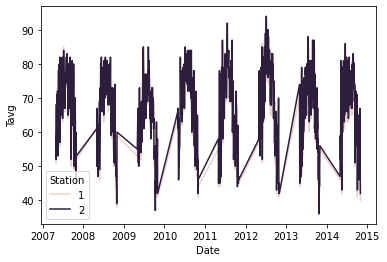

In [105]:
sns.lineplot(data=weather,y='Tavg',x='Date',hue='Station');

In [106]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   int64         
 5   Depart       2944 non-null   float64       
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   category      
 13  PrecipTotal  2944 non-null   float64       
 14  StnPressure  2944 non-null   object        
 15  SeaLevel     2944 non-null   float64       
 16  Result

The dataset is looking pretty good, but it looks like the `Sunrise` and `Sunset` columns contain a lot of missing values

In [107]:
### Replace missing values in columns with nulls
weather['Sunrise'] = weather['Sunrise'].replace(to_replace='-',value=np.nan)
weather['Sunset'] = weather['Sunset'].replace(to_replace='-',value=np.nan)

### Forward fill nulls 
weather['Sunrise'] = weather['Sunrise'].fillna(method = 'ffill')
weather['Sunset'] = weather['Sunset'].fillna(method = 'ffill')

The `Sunrise` and `Sunset` columns do not have any nulls now, but the values are strings that represent time of day.  I will convert the strings into hours from midnight.  

In [108]:
### Fix sunrise and sunset
def Str2Hrs(four_dig_string):
    hour = int(four_dig_string[:2])
    minute = int(four_dig_string[2:])
    return hour + minute/60.0


In [109]:
### Convert Sunrise and Sunset strings into floats of hours representing time of day
weather['Sunrise(hrs)'] = weather['Sunrise'].apply(Str2Hrs)
weather['Sunset(hrs)'] = weather['Sunset'].apply(Str2Hrs)

In [110]:
weather[['Station','Sunrise','Sunrise(hrs)','Sunset','Sunset(hrs)']]

,Station,Sunrise,Sunrise(hrs),Sunset,Sunset(hrs)
0,1,0448,4.800000,1849,18.816667
1,2,0448,4.800000,1849,18.816667
2,1,0447,4.783333,1850,18.833333
3,2,0447,4.783333,1850,18.833333
4,1,0446,4.766667,1851,18.850000
...,...,...,...,...,...
2939,2,0620,6.333333,1650,16.833333
2940,1,0622,6.366667,1649,16.816667
2941,2,0622,6.366667,1649,16.816667
2942,1,0623,6.383333,1647,16.783333


In [111]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Station       2944 non-null   int64         
 1   Date          2944 non-null   datetime64[ns]
 2   Tmax          2944 non-null   int64         
 3   Tmin          2944 non-null   int64         
 4   Tavg          2944 non-null   int64         
 5   Depart        2944 non-null   float64       
 6   DewPoint      2944 non-null   int64         
 7   WetBulb       2944 non-null   object        
 8   Heat          2944 non-null   object        
 9   Cool          2944 non-null   object        
 10  Sunrise       2944 non-null   object        
 11  Sunset        2944 non-null   object        
 12  CodeSum       2944 non-null   category      
 13  PrecipTotal   2944 non-null   float64       
 14  StnPressure   2944 non-null   object        
 15  SeaLevel      2944 non-null   float64 

Looking good, but I'll change the column types for any others that need it.  

In [112]:
weather['WetBulb'] = pd.to_numeric(weather['WetBulb'])
weather['Heat'] = pd.to_numeric(weather['Heat'])
weather['Cool'] = pd.to_numeric(weather['Cool'])

weather['StnPressure'] = pd.to_numeric(weather['StnPressure'])

weather['AvgSpeed'] = pd.to_numeric(weather['AvgSpeed'])


In [113]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Station       2944 non-null   int64         
 1   Date          2944 non-null   datetime64[ns]
 2   Tmax          2944 non-null   int64         
 3   Tmin          2944 non-null   int64         
 4   Tavg          2944 non-null   int64         
 5   Depart        2944 non-null   float64       
 6   DewPoint      2944 non-null   int64         
 7   WetBulb       2944 non-null   int64         
 8   Heat          2944 non-null   int64         
 9   Cool          2944 non-null   int64         
 10  Sunrise       2944 non-null   object        
 11  Sunset        2944 non-null   object        
 12  CodeSum       2944 non-null   category      
 13  PrecipTotal   2944 non-null   float64       
 14  StnPressure   2944 non-null   float64       
 15  SeaLevel      2944 non-null   float64 

`ResultDir` represents wind direction is represented by whole numbers 0-36.  I'll convert them degrees for clarity in EDA.  I assume 0deg is due North and 90deg is due East.

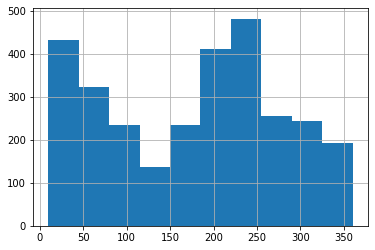

In [114]:
weather['WindDirection'] = weather['ResultDir']*10
weather.WindDirection.hist();

A few more things to clean up

In [115]:
### Finally drop duplicate and or unneccesary columns
weather.drop(['Sunrise','Sunset','ResultDir'],axis=1,inplace = True)

### Rename column for clarity
weather['WindSpeed'] = weather['ResultSpeed']
weather.drop('ResultSpeed',axis=1,inplace=True)

### Drop created column of Tnormal
weather.drop('Tnormal',axis=1,inplace=True)


### Change Station column to categorical
weather['Station'] = pd.Categorical(weather['Station'])

Finally I will add columns for representing the location and elevation of the two weather stations which are at the 2 airports in Chicago.  

In [116]:
### Add station location latitude and longitude to the dataset
weather['StationLat'] = np.where(weather['Station']==1,41.995,41.786)
weather['StationLong'] = np.where(weather['Station']==1,-87.933,-87.752)
weather['StationElev_ft'] = np.where(weather['Station']==1,662,612)

In [117]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Station         2944 non-null   category      
 1   Date            2944 non-null   datetime64[ns]
 2   Tmax            2944 non-null   int64         
 3   Tmin            2944 non-null   int64         
 4   Tavg            2944 non-null   int64         
 5   Depart          2944 non-null   float64       
 6   DewPoint        2944 non-null   int64         
 7   WetBulb         2944 non-null   int64         
 8   Heat            2944 non-null   int64         
 9   Cool            2944 non-null   int64         
 10  CodeSum         2944 non-null   category      
 11  PrecipTotal     2944 non-null   float64       
 12  StnPressure     2944 non-null   float64       
 13  SeaLevel        2944 non-null   float64       
 14  AvgSpeed        2944 non-null   float64       
 15  Sunr

Exporting cleaned up weather data for EDA.

In [118]:
weather.to_csv('weather_clean.csv')

### Fin